<a href="https://colab.research.google.com/github/hrithvik17ab/Real-Time-Fraud-Detection-PySpark/blob/main/Real_Time_Fraud_Detection_System_with_PySpark_%26_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================
# INSTALL DEPENDENCIES (Run once per Colab session if needed)
# ==============================================================================
print("INSTALLING MINIMAL DEPENDENCIES (letting Colab manage core DS libraries)...")
# Using minimal pip installs to leverage Colab's managed environment for core DS libraries,
# installing only what's specifically needed for this project (PySpark, Plotly, etc.).
!pip install -q pyspark findspark joblib plotly
!pip install -q matplotlib seaborn # For model performance visualization in Section 8
print("Minimal dependencies installed.")
print("-" * 80)

INSTALLING MINIMAL DEPENDENCIES (letting Colab manage core DS libraries)...
Minimal dependencies installed.
--------------------------------------------------------------------------------


In [ ]:
# ==============================================================================
# SECTION 1: SETUP ENVIRONMENT & IMPORTS
# ==============================================================================
print("SECTION 1: Setting up environment...")
import findspark
findspark.init() # Helps Python find the Spark installation

# Core PySpark imports for DataFrame and SQL operations, streaming, and types
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, expr, window, count, avg, lit, struct, when, sum as _sum
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType, IntegerType, BooleanType

# Standard Python libraries for data handling, time, OS operations, etc.
import json
import time
import datetime
import random
import uuid
import pandas as pd
import numpy as np
import os

# Scikit-learn components for machine learning model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest # Anomaly detection model
from sklearn.preprocessing import StandardScaler, OneHotEncoder # For feature preprocessing
from sklearn.compose import ColumnTransformer # To apply different transformations to different columns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import joblib # For saving and loading trained scikit-learn models

# Plotting libraries for visualization
import plotly.graph_objects as go
from IPython.display import display, clear_output # For dynamic Colab output
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the SparkSession, the entry point for any Spark functionality
spark = SparkSession.builder \
    .appName("RealTimeFraudDetection_Portfolio") \
    .config("spark.sql.shuffle.partitions", "10") \
    .getOrCreate()

# Set Spark's log level to ERROR to minimize verbose console output
spark.sparkContext.setLogLevel("ERROR")

print("Environment Setup Complete.")
print(f"Spark Version: {spark.version}, NumPy Version: {np.__version__}") # Display key library versions
print("-" * 80)

SECTION 1: Setting up environment...
Environment Setup Complete.
Spark Version: 3.5.1, NumPy Version: 2.0.2
--------------------------------------------------------------------------------


In [ ]:
# ==============================================================================
# SECTION 2: SYNTHETIC DATA GENERATION & INITIAL FEATURE ENGINEERING
# ==============================================================================
print("\nSECTION 2: Generating synthetic data and adding time features...")

# Define the schema for our synthetic financial transactions
# This ensures data consistency and type safety when creating Spark DataFrames.
# Includes basic transaction details and engineered time features.
transaction_fields = [
    StructField("transaction_id", StringType(), False, metadata={"comment": "Unique ID per transaction"}),
    StructField("event_timestamp", TimestampType(), False, metadata={"comment": "Time the transaction occurred"}),
    StructField("user_id", StringType(), False, metadata={"comment": "Simulated user ID"}),
    StructField("amount", DoubleType(), False, metadata={"comment": "Transaction amount"}),
    StructField("transaction_type", StringType(), False, metadata={"comment": "e.g., purchase, transfer"}),
    StructField("location", StringType(), False, metadata={"comment": "Categorical transaction location"}),
    StructField("is_fraud_actual", IntegerType(), False, metadata={"comment": "Ground truth: 1 if fraud, 0 if not"}),
    StructField("tx_hour", IntegerType(), False, metadata={"comment": "Hour of day (0-23)"}),
    StructField("tx_day_of_week", IntegerType(), False, metadata={"comment": "Day of week (Mon=0, Sun=6)"})
]
transaction_schema = StructType(transaction_fields)

# Parameters for controlling the data generation process
USER_COUNT = 40             # Number of distinct user profiles to create
N_TOTAL_BATCH_SAMPLES = 30000 # Total synthetic transactions for batch training/testing
TRANSACTION_TYPES = ['purchase', 'transfer', 'withdrawal', 'payment', 'deposit']
LOCATION_TYPES = ['domestic_online', 'international_online', 'domestic_pos', 'international_pos', 'atm']

# Create basic user profiles to introduce some behavioral patterns
user_profiles = {
    f"user_{i}": {
        'usual_max_amount': random.uniform(200, 1000),
        'usual_locations': random.sample(LOCATION_TYPES, k=random.randint(1,2)),
        'preferred_tx_type': random.choice(TRANSACTION_TYPES),
        'base_time': datetime.datetime.now() - datetime.timedelta(days=random.randint(1, 30))
    } for i in range(USER_COUNT)
}

def generate_transaction_series(num_transactions_per_user_avg=10, is_potential_anomaly_user=False):
    """
    Generates a list of synthetic transactions for a randomly chosen user.
    Introduces fraudulent transactions based on simple rules and adds time features.

    Args:
        num_transactions_per_user_avg (int): Average number of transactions to generate for the user.
        is_potential_anomaly_user (bool): Flag to increase likelihood of generating anomalies for this user.

    Returns:
        list: A list of transaction dictionaries.
    """
    user_id = f"user_{random.randint(0, USER_COUNT-1)}" # Select a random user
    profile = user_profiles[user_id]
    transactions = []
    current_time = profile['base_time']

    for _ in range(random.randint(1, int(num_transactions_per_user_avg * 1.5))):
        current_time += datetime.timedelta(minutes=random.randint(1, 60*6)) # Simulate time progression
        is_fraud = 0
        # Default transaction parameters
        amount = round(random.uniform(5.0, profile['usual_max_amount'] * 0.5), 2)
        ttype = random.choices([profile['preferred_tx_type'], random.choice(TRANSACTION_TYPES)], weights=[0.7, 0.3], k=1)[0]
        location = random.choices([random.choice(profile['usual_locations']), random.choice(LOCATION_TYPES)], weights=[0.8,0.2],k=1)[0]

        # Logic to introduce anomalies (potential fraud)
        if is_potential_anomaly_user or random.random() < 0.03:
            anomaly_type = random.choice(['high_amount', 'unusual_location_freq'])
            is_fraud = 1
            if anomaly_type == 'high_amount':
                amount = round(random.uniform(profile['usual_max_amount'] * 2.5, profile['usual_max_amount'] * 8), 2)
            elif anomaly_type == 'unusual_location_freq':
                possible_unusual_locs = [loc for loc in LOCATION_TYPES if loc not in profile['usual_locations']]
                if possible_unusual_locs: location = random.choice(possible_unusual_locs)
                else: is_fraud = 0 # Could not make it unusual, so not fraud
            # Refine: if generated "anomaly" isn't actually very anomalous, mark as not fraud
            if amount < profile['usual_max_amount'] * 1.5 and location in profile['usual_locations'] and is_fraud:
                 is_fraud = 0

        # Engineering time-based features directly during generation
        tx_hour = current_time.hour
        tx_day_of_week = current_time.weekday() # Pandas/Python: Monday=0, Sunday=6

        transactions.append({
            "transaction_id": str(uuid.uuid4()), "event_timestamp": current_time,
            "user_id": user_id, "amount": amount, "transaction_type": ttype,
            "location": location, "is_fraud_actual": is_fraud,
            "tx_hour": tx_hour, "tx_day_of_week": tx_day_of_week
        })
    return transactions

# Populate the raw batch data list
batch_data_raw = []
if USER_COUNT > 0:
    while len(batch_data_raw) < N_TOTAL_BATCH_SAMPLES:
        is_anomaly_user = random.random() < 0.10 # Some users might exhibit more anomalies
        batch_data_raw.extend(generate_transaction_series(
            num_transactions_per_user_avg=max(1, (N_TOTAL_BATCH_SAMPLES / USER_COUNT) / 2),
            is_potential_anomaly_user=is_anomaly_user
        ))
else: # Fallback if USER_COUNT is set to 0
    for _ in range(N_TOTAL_BATCH_SAMPLES):
        current_time = datetime.datetime.now() - datetime.timedelta(days=random.randint(1,30))
        tx_hour = current_time.hour
        tx_day_of_week = current_time.weekday()
        batch_data_raw.append({
            "transaction_id": str(uuid.uuid4()), "event_timestamp": current_time,
            "user_id": "default_user", "amount": round(random.uniform(5.0, 500.0),2),
            "transaction_type": random.choice(TRANSACTION_TYPES),
            "location": random.choice(LOCATION_TYPES), "is_fraud_actual": 0,
            "tx_hour": tx_hour, "tx_day_of_week": tx_day_of_week
        })

# Convert raw data to Pandas DataFrame for batch processing
batch_df_pd = pd.DataFrame(batch_data_raw)
if not batch_df_pd.empty:
    batch_df_pd['event_timestamp'] = pd.to_datetime(batch_df_pd['event_timestamp'])
    batch_df_pd = batch_df_pd.sort_values(by='event_timestamp').reset_index(drop=True)
    print(f"Generated {len(batch_df_pd)} samples for batch processing (with time features).")
    print(f"Fraudulent samples: {batch_df_pd['is_fraud_actual'].sum()}, Legitimate samples: {len(batch_df_pd) - batch_df_pd['is_fraud_actual'].sum()}")
else:
    # Fallback with minimal dummy data if generation somehow fails
    print("Error: No data generated for batch_df_pd. Using minimal dummy data.")
    current_time = datetime.datetime.now()
    batch_df_pd = pd.DataFrame({
        "transaction_id": [str(uuid.uuid4())], "event_timestamp": [current_time],
        "user_id": ["dummy_user"], "amount": [10.0], "transaction_type": ["purchase"],
        "location": ["domestic_online"], "is_fraud_actual": [0],
        "tx_hour": [current_time.hour], "tx_day_of_week": [current_time.weekday()]
    })
print("-" * 80)


SECTION 2: Generating synthetic data and adding time features...
Generated 30531 samples for batch processing (with time features).
Fraudulent samples: 4609, Legitimate samples: 25922
--------------------------------------------------------------------------------


In [ ]:
# ==============================================================================
# SECTION 3: BATCH MODEL: PREPROCESSING, TRAINING & EVALUATION
# ==============================================================================
print("\nSECTION 3: Batch model training (with time features & tuned contamination)...")
PREPROCESSOR_PATH = 'preprocessor_fraud_detection.joblib'
MODEL_PATH = 'isolation_forest_model_fraud_detection.joblib'

if not batch_df_pd.empty:
    # Define which features are numerical and which are categorical for preprocessing
    numerical_features = ['amount', 'tx_hour']
    categorical_features = ['transaction_type', 'location', 'tx_day_of_week']

    # Create a ColumnTransformer to apply different preprocessing to different columns
    # Numerical features will be scaled, categorical features will be one-hot encoded.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='drop' # Any columns not listed will be dropped
    )

    # Prepare features (X) and target (y) for model training
    X_batch = batch_df_pd[numerical_features + categorical_features]
    y_batch = batch_df_pd['is_fraud_actual']

    # Split data into training and testing sets to evaluate model performance on unseen data
    stratify_on = y_batch if y_batch.nunique() > 1 else None # Stratify only if there are multiple classes
    X_train, X_test, y_train, y_test = train_test_split(X_batch, y_batch, test_size=0.3, random_state=42, stratify=stratify_on)

    print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

    # Fit the preprocessor on the training data ONLY and transform both sets
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    joblib.dump(preprocessor, PREPROCESSOR_PATH) # Save the fitted preprocessor
    print(f"Preprocessor saved to {PREPROCESSOR_PATH}")

    # Set the contamination parameter for Isolation Forest.
    # This is an estimate of the proportion of outliers in the data.
    # It can be derived from domain knowledge, data exploration, or tuned.
    # For this iteration, a fixed value is used for experimentation to improve fraud recall.
    contamination_rate = 0.15 # Example: Adjusted value based on iterative experiments

    # Initialize and train the Isolation Forest model
    iso_forest_model = IsolationForest(n_estimators=100,
                                       contamination=contamination_rate,
                                       random_state=42,
                                       n_jobs=-1)
    print(f"Training Isolation Forest model with contamination: {contamination_rate:.4f}")
    iso_forest_model.fit(X_train_processed)

    # Make predictions on the test set
    test_predictions_raw = iso_forest_model.predict(X_test_processed)
    test_predictions_mapped = np.array([1 if x == -1 else 0 for x in test_predictions_raw]) # Convert to 0/1

    print("\n--- Model Evaluation (on Test Set) ---")
    # Display classification report (precision, recall, F1-score)
    print(classification_report(y_test, test_predictions_mapped, target_names=['Legitimate (0)', 'Fraudulent (1)'], zero_division=0))

    joblib.dump(iso_forest_model, MODEL_PATH) # Save the trained model
    print(f"Isolation Forest model saved to {MODEL_PATH}")
else:
    print("Skipping model training as batch_df_pd is empty.")
print("-" * 80)


SECTION 3: Batch model training (with time features & tuned contamination)...
Training data shape: (21371, 5), Test data shape: (9160, 5)
Preprocessor saved to preprocessor_fraud_detection.joblib
Training Isolation Forest model with contamination: 0.1500

--- Model Evaluation (on Test Set) ---
                precision    recall  f1-score   support

Legitimate (0)       0.91      0.91      0.91      7777
Fraudulent (1)       0.51      0.52      0.52      1383

      accuracy                           0.85      9160
     macro avg       0.71      0.72      0.72      9160
  weighted avg       0.85      0.85      0.85      9160

Isolation Forest model saved to isolation_forest_model_fraud_detection.joblib
--------------------------------------------------------------------------------


In [ ]:
# ==============================================================================
# SECTION 4: STREAMING PIPELINE WITH STATEFUL FEATURE ENGINEERING
# ==============================================================================
print("\nSECTION 4: Defining streaming pipeline (with UDFs expecting time features)...")
loaded_preprocessor = None
loaded_model = None

# Load the saved preprocessor and model for use in the streaming pipeline
if os.path.exists(PREPROCESSOR_PATH) and os.path.exists(MODEL_PATH):
    try:
        loaded_preprocessor = joblib.load(PREPROCESSOR_PATH)
        loaded_model = joblib.load(MODEL_PATH)
        print(f"Loaded pre-trained preprocessor from {PREPROCESSOR_PATH} and model from {MODEL_PATH}.")
    except Exception as e:
        print(f"Error loading model/preprocessor from file: {e}.")
else:
    print(f"Model ({MODEL_PATH}) or preprocessor ({PREPROCESSOR_PATH}) file not found. Streaming predictions will be impaired.")

if loaded_preprocessor and loaded_model:
    # Broadcast model and preprocessor to make them efficiently available on all Spark worker nodes
    broadcasted_preprocessor = spark.sparkContext.broadcast(loaded_preprocessor)
    broadcasted_model = spark.sparkContext.broadcast(loaded_model)

    def predict_instantaneous_fraud_udf_func(amount, transaction_type, location, tx_hour, tx_day_of_week):
        """
        Applies the loaded preprocessor and model to a single transaction's features
        to predict if it's fraudulent and return an anomaly score.
        This UDF is designed to be applied to each row in the Spark streaming DataFrame.
        """
        try:
            preprocessor_val = broadcasted_preprocessor.value
            model_val = broadcasted_model.value
            # Create a Pandas DataFrame with the correct feature names and order for the preprocessor
            data_pd = pd.DataFrame([{
                'amount': amount,
                'tx_hour': tx_hour,
                'transaction_type': transaction_type,
                'location': location,
                'tx_day_of_week': tx_day_of_week
            }])
            # The preprocessor was fit with numerical_features then categorical_features.
            # We must ensure this order if preprocessor expects it implicitly.
            # However, ColumnTransformer with named columns in `transformers=` handles order by name.
            # If it was `transformers=[('num', scaler, ['amount', 'tx_hour']), ('cat', ohe, ['type', 'loc', 'day'])]`
            # then the order in data_pd matters if we were to reorder before transform, but transform itself finds by name.

            processed_data = preprocessor_val.transform(data_pd)
            prediction = model_val.predict(processed_data)
            decision_score = model_val.decision_function(processed_data)
            is_fraud_predicted = 1 if prediction[0] == -1 else 0
            return is_fraud_predicted, float(decision_score[0])
        except Exception as e:
            # print(f"DEBUG UDF ERROR: {e}") # Uncomment for verbose UDF debugging
            return 0, 0.0 # Return a default non-fraud prediction on error

    # Schema for the output of the prediction UDF
    predict_udf_schema = StructType([
        StructField("ml_is_fraud", IntegerType(), False),
        StructField("ml_anomaly_score", DoubleType(), False)
    ])
    predict_instantaneous_fraud_udf = udf(predict_instantaneous_fraud_udf_func, predict_udf_schema)

    # Configure the rate source for simulating a stream of incoming data
    rate_per_second = 1 # Number of rows generated by the rate source per second
    raw_stream = spark.readStream \
        .format("rate") \
        .option("rowsPerSecond", rate_per_second) \
        .option("numPartitions", 1) \
        .load()

    # Use a copy of the batch data to simulate transactions for the stream
    batch_df_for_stream_pd_global_copy = batch_df_pd.copy()

    def get_transaction_for_stream_by_index(index_from_rate_value, timestamp_from_rate):
        """
        Generates a full transaction record for the stream by picking an entry
        from the `batch_df_for_stream_pd_global_copy` based on the rate source's index.
        The `timestamp_from_rate` is used as the event_timestamp for streaming operations.
        """
        try:
            if batch_df_for_stream_pd_global_copy.empty:
                 return (str(uuid.uuid4()), timestamp_from_rate, "empty_user", 0.0, "empty_type", "empty_loc", 0, 0, 0)

            idx = int(index_from_rate_value % len(batch_df_for_stream_pd_global_copy))
            pd_row = batch_df_for_stream_pd_global_copy.iloc[idx]

            # Extract and cast values to ensure type consistency for the Spark schema
            user_id_val = str(pd_row['user_id'])
            amount_val = float(pd_row['amount'])
            transaction_type_val = str(pd_row['transaction_type'])
            location_val = str(pd_row['location'])
            is_fraud_actual_val = int(pd_row['is_fraud_actual'])
            tx_hour_val = int(pd_row['tx_hour'])
            tx_day_of_week_val = int(pd_row['tx_day_of_week'])

            return (
                str(uuid.uuid4()), timestamp_from_rate, user_id_val,
                amount_val, transaction_type_val, location_val,
                is_fraud_actual_val, tx_hour_val, tx_day_of_week_val
            )
        except Exception as e:
            # print(f"DEBUG UDF ERROR (get_transaction): {e}") # Uncomment for verbose UDF debugging
            return (str(uuid.uuid4()), timestamp_from_rate, "error_user", 0.0, "error_type", "error_loc", 0, 0, 0)

    # Register the transaction generation UDF. Its return schema matches `transaction_schema`.
    generate_tx_for_stream_udf = udf(get_transaction_for_stream_by_index, transaction_schema)

    # Create the base stream of transactions
    base_transactions_stream = raw_stream \
        .select(col("timestamp").alias("processing_timestamp_rate"), col("value").alias("rate_value_index")) \
        .withColumn("tx_data", generate_tx_for_stream_udf(col("rate_value_index"), col("processing_timestamp_rate"))) \
        .select("tx_data.*") # Flatten the struct to get individual columns

    # Apply the ML model to the stream and define a watermark for event-time processing
    ml_predictions_stream = base_transactions_stream.withColumn(
        "ml_prediction_output",
        predict_instantaneous_fraud_udf( # Pass all features required by the UDF and model
            col("amount"), col("transaction_type"), col("location"),
            col("tx_hour"), col("tx_day_of_week")
        )
    ).select( # Select all original columns plus the model's output
        "*",
        col("ml_prediction_output.ml_is_fraud").alias("ml_is_fraud"),
        col("ml_prediction_output.ml_anomaly_score").alias("ml_anomaly_score")
    ).withWatermark("event_timestamp", "2 minutes") # Watermark for handling late data in windowed aggregations

    # Define a stream for stateful user behavior aggregations
    user_window_spec = "5 minutes"  # Window duration for aggregations
    user_slide_spec = "1 minute"    # How frequently the window slides
    user_aggs_stream = ml_predictions_stream \
        .groupBy( # Group by user and time window
            col("user_id"),
            window(col("event_timestamp"), user_window_spec, user_slide_spec).alias("event_window_struct")
        ) \
        .agg( # Calculate aggregates within each window
            count("*").alias("user_tx_count_window"),
            avg("amount").alias("user_avg_amount_window")
        ) \
        .select( # Select the results
            col("user_id"),
            col("event_window_struct.start").alias("window_start_time_agg"),
            col("event_window_struct.end").alias("window_end_time_agg"),
            col("user_tx_count_window"),
            col("user_avg_amount_window")
        )
    print("Streaming pipeline (ML predictions and user aggregations) defined.")
else:
    print("Skipping streaming pipeline definition as model/preprocessor was not loaded.")
    ml_predictions_stream = None # Ensure these are None if setup failed
    user_aggs_stream = None
print("-" * 80)


SECTION 4: Defining streaming pipeline (with UDFs expecting time features)...
Loaded pre-trained preprocessor from preprocessor_fraud_detection.joblib and model from isolation_forest_model_fraud_detection.joblib.
Streaming pipeline (ML predictions and user aggregations) defined.
--------------------------------------------------------------------------------


In [ ]:
# ==============================================================================
# SECTION 5: REAL-TIME ALERTING & OUTPUT (CONSOLE STREAMS)
# ==============================================================================
print("\nSECTION 5: Starting real-time alerting and user aggregation console output streams...")
ml_alert_query = None
user_aggs_console_query = None

if ml_predictions_stream is not None and user_aggs_stream is not None:
    # Stream 1: Output ML-detected fraud alerts to the console
    ml_alert_query = ml_predictions_stream \
        .filter(col("ml_is_fraud") == 1) \
        .select("transaction_id", "event_timestamp", "user_id", "amount", "ml_anomaly_score", "tx_hour", "tx_day_of_week") \
        .writeStream \
        .outputMode("append") \
        .format("console") \
        .option("truncate", "false") \
        .option("numRows", 2) \
        .queryName("ml_fraud_alerts_console") \
        .start()

    # Stream 2: Output user behavior aggregates (e.g., high activity) to the console
    user_aggs_console_query = user_aggs_stream \
        .filter(col("user_tx_count_window") >= 2) \
        .writeStream \
        .outputMode("update") \
        .format("console") \
        .option("truncate", "false") \
        .option("numRows", 2) \
        .queryName("user_behavior_aggregates_console") \
        .start()
    print("Console output streams for ML alerts and User aggregates have been initiated.")
else:
    print("Skipping console stream starts as prerequisite streaming DataFrames are not defined.")
print("-" * 80)


SECTION 5: Starting real-time alerting and user aggregation console output streams...
Console output streams for ML alerts and User aggregates have been initiated.
--------------------------------------------------------------------------------


In [ ]:
# ==============================================================================
# SECTION 6: MONITORING AND VISUALIZATION (SIMULATED LIVE DASHBOARD)
# ==============================================================================
print("\nSECTION 6: Starting monitoring and visualization (simulated live dashboard)...")
dashboard_memory_query = None
fig_dashboard = None

if ml_predictions_stream is not None:
    # Define a stream for overall dashboard statistics (e.g., total transactions, fraud counts per window)
    dashboard_overall_stats_stream = ml_predictions_stream \
        .groupBy(window(col("event_timestamp"), "30 seconds", "10 seconds")) \
        .agg(
            count("*").alias("total_tx"),
            _sum(col("ml_is_fraud")).alias("ml_predicted_fraud_tx"),
            _sum(col("is_fraud_actual")).alias("actual_fraud_tx_in_stream") # Included for comparison with synthetic truth
        ) \
        .select(
            col("window.start").alias("window_start"), col("window.end").alias("window_end"),
            col("total_tx"), col("ml_predicted_fraud_tx"), col("actual_fraud_tx_in_stream")
        )

    # Start a streaming query to write these dashboard stats to an in-memory table
    dashboard_memory_query = dashboard_overall_stats_stream \
        .writeStream \
        .outputMode("complete") \
        .format("memory") \
        .queryName("overall_fraud_dashboard_stats") \
        .start()
    print("Dashboard data stream to in-memory table 'overall_fraud_dashboard_stats' initiated.")

    # Initialize a Plotly FigureWidget for the dynamic dashboard display
    fig_dashboard = go.FigureWidget(
        data=[
            go.Bar(name='Total Transactions', x=[], y=[], marker_color='blue'),
            go.Bar(name='ML Predicted Fraud', x=[], y=[], marker_color='red'),
            go.Scatter(name='Actual Fraud (from Stream)', x=[], y=[], mode='lines+markers', marker_color='green', yaxis='y2')
        ],
        layout=go.Layout(
            title_text="Real-Time Transaction Monitoring Dashboard (Simulated)",
            xaxis_title="Time Window Start", yaxis_title="Transaction Count",
            yaxis2=dict(title='Actual Fraud Count', overlaying='y', side='right', color='green', showgrid=False),
            barmode='group', height=400
        )
    )
    display(fig_dashboard) # Display the initial empty graph structure

    print("\n--- Live Monitoring Simulation Loop (Plotly) ---")
    print("The dashboard above will attempt to update periodically. Waiting for initial data (approx 30-45s)...")
    time.sleep(30) # Allow time for stream to produce some initial aggregates

    try:
        # This loop simulates a live dashboard by periodically fetching data and updating the plot
        for i in range(30): # Loop for a fixed number of updates (e.g., 30 iterations * 5s = 2.5 minutes)
            time.sleep(5) # Frequency of dashboard updates

            active_queries = spark.streams.active
            active_queries_list_names = [q.name for q in active_queries if q.isActive and q.name]

            # Check if the critical dashboard query has stopped
            if dashboard_memory_query and not dashboard_memory_query.isActive and i > 2: # Give a few cycles for it to start
                 print(f"Dashboard memory query '{dashboard_memory_query.name}' has stopped unexpectedly. Ending plot loop.")
                 if dashboard_memory_query.exception():
                     print(f"  Exception: {dashboard_memory_query.exception()}")
                 break
            # If all queries somehow stopped
            if not active_queries_list_names and i > 2 :
                print("All streaming queries appear to have stopped. Ending plot loop.")
                break

            # Fetch the latest aggregated data from the in-memory Spark table
            df_dashboard_summary = spark.sql("SELECT * FROM overall_fraud_dashboard_stats ORDER BY window_start DESC LIMIT 30")

            # Update the Plotly figure's data traces
            if df_dashboard_summary.count() > 0:
                summary_pd = df_dashboard_summary.toPandas().sort_values(by="window_start")
                with fig_dashboard.batch_update(): # Efficiently update multiple parts of the figure
                    fig_dashboard.data[0].x = summary_pd['window_start']
                    fig_dashboard.data[0].y = summary_pd['total_tx']
                    fig_dashboard.data[1].x = summary_pd['window_start']
                    fig_dashboard.data[1].y = summary_pd['ml_predicted_fraud_tx']
                    fig_dashboard.data[2].x = summary_pd['window_start']
                    fig_dashboard.data[2].y = summary_pd['actual_fraud_tx_in_stream']

            # Clear the previous output in the Colab cell and re-display the (potentially updated) figure
            clear_output(wait=True)
            display(fig_dashboard)

            # Print status messages after re-displaying the figure
            print(f"Plot updated at: {datetime.datetime.now(datetime.timezone.utc).strftime('%Y-%m-%d %H:%M:%S %Z')}")
            print(f"Active Query Names: {active_queries_list_names if active_queries_list_names else 'None active or names not set'}")

            if df_dashboard_summary.count() > 0:
                print("\nLatest Dashboard Data ('overall_fraud_dashboard_stats'):")
                df_dashboard_summary.show(truncate=False)
            else:
                print("\nWaiting for data in 'overall_fraud_dashboard_stats' or query is still initializing...")

            # Display current status of all primary streaming queries
            query_statuses = []
            all_queries_to_check = [ml_alert_query, user_aggs_console_query, dashboard_memory_query]
            for q_obj in all_queries_to_check:
                if q_obj: # Check if query object was initialized
                     query_statuses.append(f"{q_obj.name}: {'Active' if q_obj.isActive else f'Stopped (Exc: {q_obj.exception() is not None})'}")
            print(f"Query Statuses: {', '.join(query_statuses) if query_statuses else 'No main queries were initialized.'}")

    except KeyboardInterrupt: # Allow user to manually stop the loop
        print("\nUser interrupted the monitoring loop.")
    except Exception as e_loop: # Catch any other errors during the loop
        print(f"An error occurred during the Plotly monitoring loop: {e_loop}")
        import traceback
        traceback.print_exc()
    finally:
        # This block ensures streaming queries are stopped when the loop finishes or on error
        print("\n--- Stopping Streaming Queries (End of Section 6) ---")
        if spark and hasattr(spark, 'streams') and spark.streams:
            active_queries_at_stop_attempt = spark.streams.active
            if active_queries_at_stop_attempt:
                for q_to_stop in active_queries_at_stop_attempt:
                    try:
                        status_msg = "Status unknown"
                        # Access status safely
                        if hasattr(q_to_stop, 'status') and q_to_stop.status and 'message' in q_to_stop.status:
                            status_msg = q_to_stop.status['message']
                        print(f"Attempting to stop query: {q_to_stop.name or q_to_stop.id} (Current Status: {status_msg})")
                        q_to_stop.stop()
                    except Exception as e_stop:
                        print(f"Error trying to stop query {q_to_stop.name or q_to_stop.id}: {e_stop}")

                print("Waiting briefly for queries to process stop requests (10s)...")
                time.sleep(10)

                print("Checking status after stop requests for Section 6...")
                still_active_queries_s6 = spark.streams.active
                if still_active_queries_s6:
                    for q_active in still_active_queries_s6:
                         status_msg = "Status unknown"
                         if hasattr(q_active, 'status') and q_active.status and 'message' in q_active.status:
                            status_msg = q_active.status['message']
                         print(f"Query {q_active.name or q_active.id} is STILL ACTIVE after stop attempt. Status: {status_msg}")
                else:
                    print("All queries appear to have successfully stopped after Section 6.")
            else:
                print("No active streams found to stop at the end of Section 6.")
        print("Finished attempting to stop all active streaming queries from Section 6.")
else:
    print("Skipping monitoring and visualization (Section 6) as ml_predictions_stream was not defined.")
print("-" * 80)

In [ ]:
# ==============================================================================
# SECTION 7: STATIC PLOT OF COLLECTED DASHBOARD DATA (REVISED SPARK CHECK)
# ==============================================================================
print("\nSECTION 7: Creating a static plot from collected dashboard data...")

import plotly.graph_objects as go # Required for Plotly figures
import pandas as pd # Required for converting Spark DataFrame to Pandas for Plotly

# Check if Spark session is operational before proceeding
spark_session_operational_s7 = False
if 'spark' in globals() and spark is not None:
    try:
        # Perform a very simple Spark action to confirm the session responds
        spark.sql("SELECT 1").collect()
        spark_session_operational_s7 = True
        print("Spark session appears to be operational for Section 7.")
    except Exception as e_spark_check_s7:
        print(f"Spark session check failed for Section 7: {e_spark_check_s7}.")
        print("Assuming session is not fully operational for new queries. This can occur after long streaming runs.")
        spark_session_operational_s7 = False
else:
    print("Global Spark session variable 'spark' not found or is None.")

if not spark_session_operational_s7:
    print("Spark session is not active or not responding. Cannot create static plot for Section 7.")
else:
    try:
        print("Attempting to query 'overall_fraud_dashboard_stats' for static plot...")
        table_exists_s7 = False
        # Verify table existence and if it has content
        try:
            if spark.catalog.tableExists("overall_fraud_dashboard_stats"):
                # Check for at least one row to confirm data was written
                # Using a direct action like count() on the table can also verify session responsiveness
                if spark.table("overall_fraud_dashboard_stats").limit(1).count() > 0 :
                    table_exists_s7 = True
                    print("Table 'overall_fraud_dashboard_stats' found and contains data.")
                else:
                    print("Table 'overall_fraud_dashboard_stats' exists but is empty.")
            else:
                print("Table 'overall_fraud_dashboard_stats' does not exist in Spark catalog.")
        except Exception as e_table_check_s7:
            # This might happen if Spark session died unexpectedly during the check itself
            print(f"Could not definitively verify 'overall_fraud_dashboard_stats'. Error: {e_table_check_s7}")
            print("The Spark session might have become unresponsive.")


        if table_exists_s7:
            # Query all valid data from the in-memory table for the static plot
            # Ensure total_tx is not null as an extra check for valid window data
            collected_dashboard_data_df = spark.sql("SELECT * FROM overall_fraud_dashboard_stats WHERE total_tx IS NOT NULL ORDER BY window_start")

            collected_count_s7 = collected_dashboard_data_df.count() # Action to trigger collection if needed

            if collected_count_s7 > 0:
                collected_dashboard_data_pd = collected_dashboard_data_df.toPandas() # Convert to Pandas for Plotly

                print(f"\nCollected {len(collected_dashboard_data_pd)} valid time windows for static plotting.")
                if not collected_dashboard_data_pd.empty:
                     print("Sample of collected data (first 5 rows):")
                     print(collected_dashboard_data_pd.head())

                # Create the static Plotly figure
                static_fig = go.Figure()

                # Add Total Transactions Bar
                static_fig.add_trace(go.Bar(
                    x=collected_dashboard_data_pd['window_start'],
                    y=collected_dashboard_data_pd['total_tx'],
                    name='Total Transactions',
                    marker_color='royalblue',
                    opacity=0.8
                ))

                # Add ML Predicted Fraud Bar
                static_fig.add_trace(go.Bar(
                    x=collected_dashboard_data_pd['window_start'],
                    y=collected_dashboard_data_pd['ml_predicted_fraud_tx'],
                    name='ML Predicted Fraud',
                    marker_color='crimson',
                    opacity=0.8
                ))

                # Add Actual Fraud as a line on a secondary y-axis
                static_fig.add_trace(go.Scatter(
                    x=collected_dashboard_data_pd['window_start'],
                    y=collected_dashboard_data_pd['actual_fraud_tx_in_stream'],
                    name='Actual Fraud (from Stream Data)',
                    mode='lines+markers',
                    marker_color='forestgreen',
                    line=dict(width=2),
                    yaxis='y2'
                ))

                # Update layout for clarity and aesthetics
                static_fig.update_layout(
                    title_text='<b>Static Summary: Transaction Monitoring Over Time</b>',
                    xaxis_title='Time Window Start',
                    yaxis_title='Transaction Count (Bars)',
                    yaxis2=dict(
                        title='Actual Fraud Count (Line)',
                        overlaying='y',
                        side='right',
                        showgrid=False,
                        color='forestgreen',
                        titlefont=dict(color='forestgreen'),
                        tickfont=dict(color='forestgreen')
                    ),
                    barmode='group',
                    legend=dict(
                        orientation="h",
                        yanchor="bottom",
                        y=1.02,
                        xanchor="right",
                        x=1
                    ),
                    plot_bgcolor='rgba(245, 245, 245, 1)',
                    paper_bgcolor='white',
                    font=dict(family="Arial, sans-serif", size=12, color="black"),
                    height=550,
                    xaxis_tickangle=-45,
                    margin=dict(l=60, r=60, b=120, t=100, pad=5)
                )

                static_fig.show() # Display the static plot in Colab output
            else:
                print("No valid data (where total_tx is not null) found in 'overall_fraud_dashboard_stats' for static plot.")
        elif not table_exists_s7:
             print("Table 'overall_fraud_dashboard_stats' does not exist or was confirmed empty. Cannot generate static plot.")

    except Exception as e_s7:
        print(f"An error occurred during static plot generation (Section 7): {e_s7}")
        import traceback
        traceback.print_exc()

print("-" * 80)
print("Static plotting section (Section 7) finished.")


SECTION 7: Creating a static plot from collected dashboard data...
Spark session appears to be operational for Section 7.
Attempting to query 'overall_fraud_dashboard_stats' for static plot...
Table 'overall_fraud_dashboard_stats' found and contains data.

Collected 44 valid time windows for static plotting.
Sample of collected data (first 5 rows):
         window_start          window_end  total_tx  ml_predicted_fraud_tx  \
0 2025-06-02 08:51:40 2025-06-02 08:52:10         7                      1   
1 2025-06-02 08:51:50 2025-06-02 08:52:20        17                      1   
2 2025-06-02 08:52:00 2025-06-02 08:52:30        27                      1   
3 2025-06-02 08:52:10 2025-06-02 08:52:40        30                      0   
4 2025-06-02 08:52:20 2025-06-02 08:52:50        30                      1   

   actual_fraud_tx_in_stream  
0                          1  
1                          7  
2                         10  
3                         12  
4                       

--------------------------------------------------------------------------------
Static plotting section (Section 7) finished.



SECTION 8: Reviewing performance of the batch-trained model...

--- Model Performance Metrics (on Test Set from Section 3) ---

Accuracy: 0.8527

Classification Report:
                precision    recall  f1-score   support

Legitimate (0)       0.91      0.91      0.91      7777
Fraudulent (1)       0.51      0.52      0.52      1383

      accuracy                           0.85      9160
     macro avg       0.71      0.72      0.72      9160
  weighted avg       0.85      0.85      0.85      9160


Confusion Matrix (numerical):
[[7089  688]
 [ 661  722]]


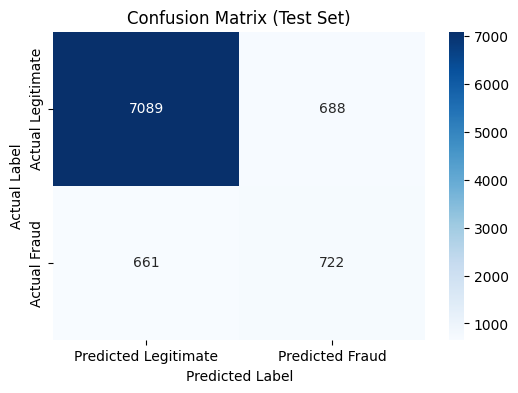

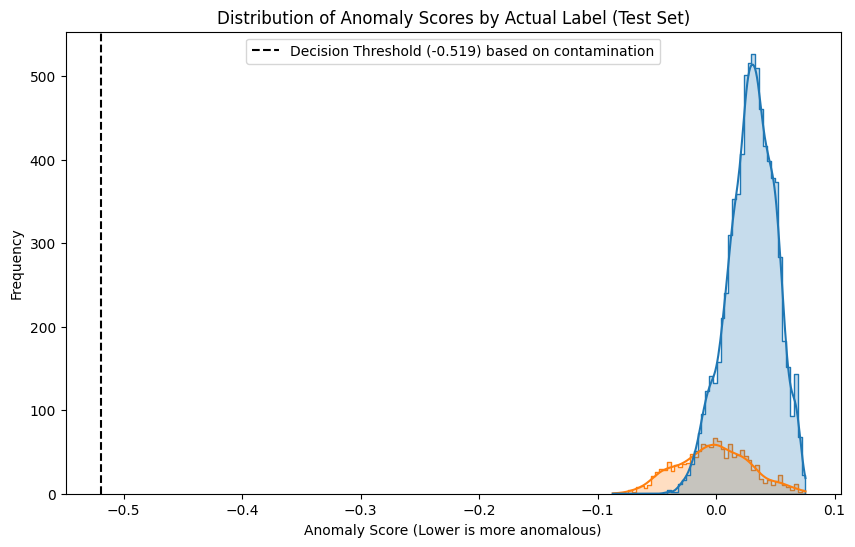


Interpretation Notes (refer to metrics above):
- Accuracy: Overall percentage of correctly classified transactions.
- Precision (Fraudulent): Of those predicted as fraud, how many truly are.
- Recall (Fraudulent): Of all actual frauds, how many were caught.
- F1-Score: Harmonic mean of Precision and Recall, useful for imbalanced classes.
- Confusion Matrix & Score Distribution: Help visualize model behavior and error types.
--------------------------------------------------------------------------------
Model performance review section (Section 8) finished.
--------------------------------------------------------------------------------
END OF SCRIPT


In [ ]:
# ==============================================================================
# SECTION 8: MODEL PERFORMANCE REVIEW (FROM BATCH TRAINING IN SECTION 3)
# ==============================================================================
print("\nSECTION 8: Reviewing performance of the batch-trained model...")

# Check if necessary variables from Section 3 are available in the global scope
if 'y_test' in globals() and 'test_predictions_mapped' in globals() and \
   'X_test_processed' in globals() and 'iso_forest_model' in globals() and \
   'preprocessor' in globals(): # Added preprocessor check for full context if needed

    print("\n--- Model Performance Metrics (on Test Set from Section 3) ---")
    # 1. Accuracy Score
    accuracy = accuracy_score(y_test, test_predictions_mapped)
    print(f"\nAccuracy: {accuracy:.4f}")

    # 2. Classification Report (Precision, Recall, F1-Score)
    print("\nClassification Report:")
    report = classification_report(y_test, test_predictions_mapped, target_names=['Legitimate (0)', 'Fraudulent (1)'], zero_division=0)
    print(report)

    # 3. Confusion Matrix (numerical array)
    print("\nConfusion Matrix (numerical):")
    cm = confusion_matrix(y_test, test_predictions_mapped)
    print(cm)

    # 4. Visualize Confusion Matrix using Matplotlib/Seaborn for better readability
    try:
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted Legitimate', 'Predicted Fraud'],
                    yticklabels=['Actual Legitimate', 'Actual Fraud'])
        plt.title('Confusion Matrix (Test Set)')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.show()
    except Exception as e_cm_plot:
        print(f"\nCould not plot confusion matrix. Error: {e_cm_plot}")

    # 5. Analyze and plot distribution of Anomaly Scores from Isolation Forest
    try:
        anomaly_scores = iso_forest_model.decision_function(X_test_processed) # Raw anomaly scores
        df_scores = pd.DataFrame({'score': anomaly_scores, 'actual_label': y_test})

        plt.figure(figsize=(10, 6))
        sns.histplot(data=df_scores, x='score', hue='actual_label', kde=True, bins=50, element="step")
        plt.title('Distribution of Anomaly Scores by Actual Label (Test Set)')
        plt.xlabel('Anomaly Score (Lower is more anomalous)')
        plt.ylabel('Frequency')
        # The offset_ attribute in IsolationForest corresponds to the threshold set by contamination
        plt.axvline(iso_forest_model.offset_, color='k', linestyle='dashed', linewidth=1.5,
                    label=f'Decision Threshold ({iso_forest_model.offset_:.3f}) based on contamination')
        plt.legend()
        plt.show()
    except Exception as e_score_plot:
        print(f"\nCould not plot anomaly scores. Error: {e_score_plot}")

    print("\nInterpretation Notes (refer to metrics above):")
    print("- Accuracy: Overall percentage of correctly classified transactions.")
    print("- Precision (Fraudulent): Of those predicted as fraud, how many truly are.")
    print("- Recall (Fraudulent): Of all actual frauds, how many were caught.")
    print("- F1-Score: Harmonic mean of Precision and Recall, useful for imbalanced classes.")
    print("- Confusion Matrix & Score Distribution: Help visualize model behavior and error types.")
else:
    print("\nCould not find necessary variables (e.g., 'y_test', 'test_predictions_mapped') for model review.")
    print("Please ensure Section 3 (Batch Model Training and Evaluation) was run successfully in this session.")

print("-" * 80)
print("Model performance review section (Section 8) finished.")
print("-" * 80)
print("END OF SCRIPT")